### Imports

In [1]:
import os
import json
import sys
import pandas as pd
import random
import operator
import numpy as np
import numpy.random
import netCDF4 as nc
import xarray as xr
import re
import pickle as pkl
import torch
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from torch.autograd import Variable
from math import radians, cos, sin, asin, sqrt
from torch.utils.data import Dataset
from datetime import datetime, timedelta
from time import time, strftime, gmtime
from scipy.stats import binned_statistic

sys.path.append('/home/ninow/master_thesis/code/project/')
from utils.data import DataUtils
from utils import ModelUtils
from model import Baseline

### Define Helper Methods

In [2]:
# this dictionary can be used to get the days that have already passed for a certain month in year
passed_days_per_month_dict = {
    1 : 0,
    2 : 31,
    3 : 59,
    4 : 90,
    5 : 120,
    6 : 151,
    7 : 181,
    8 : 212,
    9 : 243,
    10 : 273,
    11 : 304,
    12 : 334
}
# transform filenames of type YYMMDDHH -> time
def getTimeFromFileName(file_names, lead=1):
    times = []
    for file_name in file_names:
        year = file_name[:2]
        month = file_name[2:4]
        day = file_name[4:6]
        hour = file_name[6:8]
        # by loading the observation data again for the init time, we need to add the lead time for the prediction
        dt = datetime(year=2000+int(year), month=int(month), day=int(day), hour=int(hour)) + timedelta(hours=lead)
        times += [np.datetime64(dt)]
    return times

# calculate the time [0,3,...,21] for which the label stands for
def getInversedHour(time_data, lead_idx):
    inversed_hour = []
    for l in lead_idx:
        x = np.arccos(time_data[l][0])
        if time_data[l][1] < 0:
            x = -x
            inversed_hour += [24 + int((x / (2 * np.pi)) * 24)]
        else:
            inversed_hour += [int((x / (2 * np.pi)) * 24)]
    return inversed_hour


# calculate the month [1,...,12] for which the label stands for
def getInversedMonth(time_data, lead_idx):
    inversed_month = []
    for l in lead_idx:
        x = np.arccos(time_data[l][2])
        if time_data[l][3] < 0:
            x = -x
            inversed_month += [12 + int((x / (2 * np.pi)) * 12) + 1]
        else:
            inversed_month += [int((x / (2 * np.pi)) * 12) + 1]
    return inversed_month


# calculates all raw COSMO-1 files, that have not yet been preprocessed,
# according all the preprocessed files in DESTINATION
def get_all_files(src_path, stations, inits):
    all_files = []

    # get all files from all the station folder if inis is None. In this case we are interested in the per
    # station and init time preprocessed single files.
    if inits is None:
        for s in stations:
            all_files += [(str(s), f[:-4]) for f in os.listdir(src_path + '/station_init/grid_size_9/' + 'Station_' + str(s))]
    # generate files according to all stations and init times that were found in the data set
    else:
        # the source path is not appended to reduce redundancy
        for s in stations:
            all_files += [(s, init) for init in inits]

    # only keep one file for each day and initialization time
    all_files = set(all_files)

    return all_files



# get all file paths for the stations under the given source path
def getFilesToProcess(ADDRESSdata, DESTINATION, Dates):

    # get all comso folders, representing one run (output) of the COSMO-1 model
    all_cosmo_folders = [(D[-12:-4], D[-4:]) for D in os.listdir(ADDRESSdata) if D[0] == '1' and D[-4] == '_']

    # return all files that have not yet been processed
    return [f[0] + f[1] for f in all_cosmo_folders if f[0] in Dates]

# loads the data statistics (min, max, mean, std) for each feature
# and adds the input parameters to the experiment configuration
def getDataStatistics(config):
    data_statistics = None
    # Load statistics from data set for feature scaling
    if config['is_normalization']:
        with open(config['input_source'] + "/feature_summary_grid_%s.pkl" % config['original_grid_size'], "rb") as input_file:
            feature_summary = pkl.load(input_file)
            # get numbers for normalization
            data_statistics = {
                'mean': feature_summary.sel(characteristic = 'mean').data,
                'var': feature_summary.sel(characteristic = 'var').data,
                'min': feature_summary.sel(characteristic = 'min').data,
                'max': feature_summary.sel(characteristic = 'max').data
            }
            config['input_parameters'] = list(feature_summary.coords['feature'].data)
    return data_statistics


def normalizationValues(ADDR, FOLDERS, VARS, WithTopo):
    # only a subset of all cosmo-1 outputs are samplet to generate approximated measurements
    folder_samples = min(10, len(FOLDERS))
    point_samples = 10
    total_samples = folder_samples * point_samples

    MEAN = np.array([0] * len(VARS), dtype='d')
    STD = np.array([0] * len(VARS), dtype='d')
    MAX = np.array([0] * len(VARS), dtype='d')
    MIN = np.array([np.inf] * len(VARS), dtype='d')

    selected_folders = random.sample(FOLDERS, folder_samples)
    for n in range(folder_samples):
        F = selected_folders[n]
        dataset = nc.Dataset(ADDR + '/' + F + '/c1ffsurf000.nc')
        for i in range(len(VARS)):
            selected_points = np.random.choice(dataset[VARS[i]][:].flatten(), size=point_samples, replace=False)
            MAX[i] = np.max((MAX[i], np.max(selected_points)))
            MIN[i] = np.min((MIN[i], np.min(selected_points)))
            MEAN[i] += np.sum(selected_points)

    MEAN *= 1 / total_samples

    for n in range(folder_samples):
        F = selected_folders[n]
        dataset = nc.Dataset(ADDR + '/' + F + '/c1ffsurf000.nc')
        for i in range(len(VARS)):
            selected_points = np.random.choice(dataset[VARS[i]][:].flatten(), size=point_samples, replace=False)
            STD[i] += np.sum((selected_points - MEAN[i]) ** 2)
    STD = np.sqrt(STD / total_samples)

    if WithTopo:
        MEAN = np.append([530, 0], MEAN)
        STD = np.append([500, 1], STD)

    return MEAN, STD, MAX, MIN

# standardization of data by mean and standard deviation
def standardize(data, mean, std):
    data -= mean
    data = np.divide(data, std)
    return data

# normalization of data approximately between [0,1]
def normalize(data, minimum, maximum, p):
    data -= minimum
    data = np.divide(data, maximum-minimum)

    if np.max(np.abs(data)) > 1.1:
        print("Problematic feature: %s with max %s and min %s" % (p, np.max(data), np.min(data)))
        #plt.imshow(data)
        #plt.colorbar()
        #plt.show()
        #raise Exception('Problem im normalization, feature out of the [0,1] range.' % data)
    return data

def normalizeTimeFeatures(data):
    return np.vectorize(lambda x: (x+1)/2)(data)

# normalize latitude [42.8, 49.8] to [0,1]
def normalizeLatitude(data):
    return normalize(data, 42.8, 49.8)

# normalize longitude [0.3, 16.6] to [0,1]
def normalizeLongitude(data):
    return normalize(data, 0.3, 16.6)

# normalize height grid:[-5.4, 4267.5] and stations:[203.2, 3580] in to [0,1]
def normalizeHeight(data):
    return normalize(data, -5.4, 4267.5)

# normalize soil type [1:9] in to [0:1] (discrete)
def normalizeSoilType(data):
    return normalize(data, 1, 9)

def normalizeDiffFeature(data):
    minimum, maximum = data.min(), data.max()
    return np.vectorize(lambda x: normalize(x, minimum, maximum))(data)

# do not transform the data
def identity(data):
    return data

# returns a list of transformation functions for each parameters data
# param_normalizaiton: dict, e.g. param -> feature_transformation
# statistics: dict, e.g. list of values of 'mean', 'std', 'min', 'max' for each feature
def getFeatureScaleFunctions(param_normalization, statistics=None):
    n_params = len(param_normalization.keys())
    # if no statistic is given, we return an identity function
    scale_functions = [lambda x : identity(x)] * n_params
    if statistics != None:
        for idx, p in enumerate(param_normalization.keys()):
            if param_normalization[p] == 'n':
                scale_functions[idx] = lambda x, idx=idx, p=p : normalize(x, statistics['min'][idx], statistics['max'][idx], p)
            elif param_normalization[p] == 's':
                scale_functions[idx] = lambda x, idx=idx, p=p: standardize(x, statistics['mean'][idx], statistics['var'][idx])
            else:
                pass
    return scale_functions

# construct data set with time invariant features per station (-grid)
def getTimeInvariantFeatures(TOPO, OBS, Features):
    # TOPO: topological data (netCDF)
    # OBS: observation data (netCDF)
    # Features: all time invariant features that have to be preprocessed
    
    GridSizeLat, GridSizeLon = TOPO.dims['rlat'], TOPO.dims['rlon']
    grid_indices_lat, grid_indices_lon = range(GridSizeLat), range(GridSizeLon)
    n_grid_points = GridSizeLat * GridSizeLon
    n_features = len(Features)
    
    # container for all features, for all station grids
    DATA = np.zeros((GridSizeLat, GridSizeLon, n_features))
    RAW_DATA = np.zeros((GridSizeLat, GridSizeLon, 5))


    # height features
    DATA[:,:,Features.index('HH')] = np.vectorize(lambda x: normalizeHeight(x))(TOPO['HH'])
    RAW_DATA[:,:,0] = TOPO['HH']

    # height difference between grid point and grid point is 0
    DATA[:, :, Features.index('HH_DIFF')] = np.zeros((GridSizeLat, GridSizeLon))

    # fraction of land feature
    DATA[:, :, Features.index('FR_LAND')] = TOPO['FR_LAND']

    # soil type feature
    DATA[:, :, Features.index('SOILTYP')] = np.vectorize(lambda x: normalizeSoilType(x))(
                                                       TOPO['SOILTYP'])

    # latitiude features
    DATA[:, :, Features.index('LAT')] = np.vectorize(lambda x: normalizeLatitude(x))(
                                                            TOPO['lat'])
    RAW_DATA[:,:,1] = TOPO['lat']
    DATA[:, :, Features.index('LAT_DIFF')] = np.zeros((GridSizeLat, GridSizeLon))
    DATA[:, :, Features.index('RLAT')] = np.repeat(TOPO['rlat'].data[...,None], GridSizeLon, 1)
    RAW_DATA[:,:,3] = np.repeat(TOPO['rlat'].data[...,None], GridSizeLon, 1)


    # longitued features
    DATA[:, :, Features.index('LON')] = np.vectorize(lambda x: normalizeLongitude(x))(
                                                            TOPO['lon'])
    RAW_DATA[:,:,2] = TOPO['lon']
    DATA[:, :, Features.index('LON_DIFF')] = np.zeros((GridSizeLat, GridSizeLon))
    DATA[:, :, Features.index('RLON')] = np.repeat(TOPO['rlon'].data[...,None], GridSizeLat, 1).T
    RAW_DATA[:,:,4] = np.repeat(TOPO['rlon'].data[...,None], GridSizeLat, 1).T

    DATA[:, :, Features.index('ABS_2D_DIST')] = np.zeros((GridSizeLat, GridSizeLon))
    DATA[:, :, Features.index('ABS_2D_DIST_RAW')] = np.zeros((GridSizeLat, GridSizeLon))

    # normalize height difference
    DATA[:, :, Features.index('HH_DIFF')] = np.zeros((GridSizeLat, GridSizeLon))
    # normalize height difference
    DATA[:, :, Features.index('LAT_DIFF')] = np.zeros((GridSizeLat, GridSizeLon))
    # normalize height difference
    DATA[:, :, Features.index('LON_DIFF')] = np.zeros((GridSizeLat, GridSizeLon))
    # normalize horizontal distance
    DATA[:, :, Features.index('ABS_2D_DIST')] = np.zeros((GridSizeLat, GridSizeLon))

    # generate data array with station dependent grid point features
    grid_data = xr.DataArray(DATA,
                             dims=('idx_lat', 'idx_lon', 'feature'),
                             coords=[grid_indices_lat, grid_indices_lon, Features])

    # generate data array with positional information of each station
    grid_raw_data = xr.DataArray(RAW_DATA,
                                    dims = ('idx_lat', 'idx_lon', 'raw_feature'),
                                    coords = [grid_indices_lat, grid_indices_lon, ['raw_height',
                                                       'raw_lat', 'raw_lon',
                                                       'raw_rlat', 'raw_rlon']])
    
    station_data = xr.DataArray(np.dstack((DATA[:,:,Features.index('HH')],
                                           DATA[:, :, Features.index('LAT')],
                                           DATA[:, :, Features.index('LON')]),),
                                dims=('idx_lat', 'idx_lon', 'station_feature'),
                                coords = [grid_indices_lat, grid_indices_lon, ['height', 'lat', 'lon']])
    
                             # return data set generated out of data arrays
    return xr.Dataset({'grid_data': grid_data,
                     'grid_data_raw' : grid_raw_data,
                     'station_data' : station_data})

In [3]:
def load_checkpoint(path, model, optimizer):
    file_path = path + '/model_best.pth.tar'
    if os.path.isfile(file_path):
        print("Loading checkpoint from: %s" % file_path)
        checkpoint = torch.load(file_path)
        epoch = checkpoint['epoch'] + 1
        best_epoch_test_rmse = checkpoint['best_epoch_test_rmse']
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        print("Loaded checkpoint with best test rmse %s (epoch %s)" % (best_epoch_test_rmse, checkpoint['epoch']))
    else:
        raise Exception("No checkpoint found at %s" % file_path)
    return model, optimizer, epoch, best_epoch_test_rmse

def load_trained_network(config):
    
    # assign all program arguments to local variables
    with open(config['model']['path']) as handle:
        ModelDict = json.loads(handle.read())

    # initialize network, optimizer and loss function
    net = Baseline.model_factory(model_dict=ModelDict, params=len(config['input_parameters']),
                                 time_invariant_params=len(config['grid_time_invariant_parameters']),
                                 grid=config['grid_size'], prediction_times=config['prediction_times'])

    # get optimizer config
    optimizer_config = config['optimizer']

    # if not explicitly specified, don't use regularization
    if 'weight_decay' not in optimizer_config: optimizer_config['weight_decay'] = 0

    optimizer = torch.optim.SGD(net.parameters(), lr=optimizer_config['learning_rate'],
                                momentum=optimizer_config['momentum'], weight_decay=optimizer_config['weight_decay'])


    net, optimizer, *_ = load_checkpoint(config['trained_model_output_path'] + '/stored_models/run_0', model=net,
                                                    optimizer=optimizer)

    if torch.cuda.is_available():
        net.cuda()

    # we do not train, but only output the evaluation of the network on train and test data
    net.eval()
    
    return net

In [4]:
def network_output_wrapper(net, X):
    grid_data = getVariable(torch.Tensor(X[:,:22])).float()
    if X.shape[1] >= 30:
        station_time_inv_input = getVariable(torch.Tensor(X[:,22:25])).float()
    else:
        station_time_inv_input = None
    time_data = getVariable(torch.Tensor(X[:,-5:])).float()
    network_output = net(grid_data, time_data, station_time_inv_input).data.cpu().numpy()
    
    grid_data.data.cpu()
    station_time_inv_input.data.cpu()
    time_data.data.cpu()
    
    return network_output

# wrapper for pytorch network output
f = lambda X: network_output_wrapper(net=net, X=X)

def getVariable(tensor):
    if torch.cuda.is_available():
        input = Variable(tensor.cuda())
    else:
        input = Variable(tensor)
    return input.float()

In [5]:
# load station positions to plot them on map
station_data = pkl.load(open('/mnt/ds3lab-scratch/ninow/preprocessed_data/station/grid_size_1/time_invariant_data_per_station.pkl','rb'))
station_positions = station_data.station_position.sel(positinal_attribute = ['rlat', 'rlon','height_raw'])
stations = station_data.station
station_names = station_data.station_name

station_idx_mapping = {}
for s_idx, s in enumerate(stations.data):
    station_idx_mapping[s] = s_idx

# Uncertainty estimation test data

In [197]:
dropout = '0_1' #'0_1', '0_25', '0_5'

### Load network ready data

In [198]:
with open('/mnt/ds3lab-scratch/ninow/preprocessed_data/network_ready_data/test_data','rb') as handle:
    network_ready_data_temperature_prediction = pkl.load(handle)

### Load trained network

In [199]:
config_temperature_prediction = pkl.load(open('/mnt/ds3lab-scratch/ninow/final_results/network/model_predictions/knn_1/shap/config.pkl', 'rb'))
config_temperature_prediction['experiment_path'] = '/mnt/ds3lab-scratch/ninow/final_results/variational_dropout/temperature_prediction/dropout_%s' % dropout
model = config_temperature_prediction['model']
model['path'] = '/mnt/ds3lab-scratch/ninow/final_results/variational_dropout/temperature_prediction/dropout_%s/models/FC_L3_1024_256_64_TD_GTI_STI.txt' % dropout
config_temperature_prediction['model'] = model
config_temperature_prediction['trained_model_output_path'] = '/mnt/ds3lab-scratch/ninow/final_results/variational_dropout/temperature_prediction/dropout_%s/FC_L3_1024_256_64_TD_GTI_STI_grid_1_bs_64_tf_0.1_optim_sgd_lr_0.0005_sl_24' % dropout

In [200]:
net_temperature_prediction = load_trained_network(config_temperature_prediction)

{'dropout_prop': 0.1, 'station_time_invariant': True, 'time_data': True, 'n_fc3': 64, 'n_fc1': 1024, 'type': 'FC', 'n_fc2': 256, 'layers': 3, 'name': 'FC_L3_1024_256_64_TD_GTI_STI', 'grid_time_invariant': True, 'fc_layers': 3}
Model uses dropout probability: 0.1
Loading checkpoint from: /mnt/ds3lab-scratch/ninow/final_results/variational_dropout/temperature_prediction/dropout_0_1/FC_L3_1024_256_64_TD_GTI_STI_grid_1_bs_64_tf_0.1_optim_sgd_lr_0.0005_sl_24/stored_models/run_0/model_best.pth.tar
Loaded checkpoint with best test rmse 1.3230336509007303 (epoch 29)


### Run model 100 times with dropout

In [201]:
n_eval = 1000
data_temperature_prediction = np.array(network_ready_data_temperature_prediction.as_matrix()[:,2:-2], dtype=np.float64)
ensemble_result_temperature_prediction = np.zeros((n_eval, network_ready_data_temperature_prediction.shape[0]))
for run in range(n_eval):
    net_temperature_prediction.train(True)
    ensemble_result_temperature_prediction[run] = network_output_wrapper(net_temperature_prediction, data_temperature_prediction)[:,0]

### Calculate mean prediction and std. dev. over the 100 runs

In [202]:
mean_prediction_temperature_prediction, var_prediction_temperature_prediction = np.mean(ensemble_result_temperature_prediction, axis=0),np.var(ensemble_result_temperature_prediction, axis=0)

In [203]:
label_temperature_prediction = np.array(network_ready_data_temperature_prediction.as_matrix()[:,-2], dtype=np.float64)
model_error_temperature_prediction = mean_prediction_temperature_prediction - label_temperature_prediction
cosmo_error_temperature_prediction = np.array(network_ready_data_temperature_prediction.as_matrix()[:,-1] - np.array(network_ready_data_temperature_prediction.as_matrix()[:,-2], dtype=np.float64))
correction_temperature_prediction = mean_prediction_temperature_prediction - np.array(network_ready_data_temperature_prediction.as_matrix()[:,-2], dtype=np.float64)
prediction_temperature_prediction = mean_prediction_temperature_prediction

# Uncertainty Estimation on Test Data with Error Prediction

### Load network ready data

In [204]:
with open('/mnt/ds3lab-scratch/ninow/preprocessed_data/network_ready_data/test_data','rb') as handle:
    network_ready_data_error_prediction = pkl.load(handle)
with open('/mnt/ds3lab-scratch/ninow/preprocessed_data/network_ready_data/train_data','rb') as handle:
    network_ready_data_error_prediction_train = pkl.load(handle)

In [205]:
data_error_prediction = np.array(network_ready_data_error_prediction.as_matrix()[:,2:-2], dtype=np.float64)
label_error_prediction = (network_ready_data_error_prediction.as_matrix()[:,-1] - network_ready_data_error_prediction.as_matrix()[:,-2])

### Load trained network

In [206]:
config_error_prediction = pkl.load(open('/mnt/ds3lab-scratch/ninow/final_results/network/model_predictions/knn_1/shap/config.pkl', 'rb'))
config_error_prediction['experiment_path'] = '/mnt/ds3lab-scratch/ninow/final_results/variational_dropout/error_prediction/dropout_%s' % dropout
model = config_error_prediction['model']
model['path'] = '/mnt/ds3lab-scratch/ninow/final_results/variational_dropout/error_prediction/dropout_%s/models/FC_L3_1024_256_64_TD_GTI_STI.txt' % dropout
config_error_prediction['model'] = model
config_error_prediction['trained_model_output_path'] = '/mnt/ds3lab-scratch/ninow/final_results/variational_dropout/error_prediction/dropout_%s/FC_L3_1024_256_64_TD_GTI_STI_grid_1_bs_64_tf_0.1_optim_sgd_lr_0.0005_sl_24' % dropout

In [207]:
net_error_prediction = load_trained_network(config_error_prediction)

{'dropout_prop': 0.1, 'station_time_invariant': True, 'time_data': True, 'n_fc3': 64, 'n_fc1': 1024, 'type': 'FC', 'n_fc2': 256, 'layers': 3, 'name': 'FC_L3_1024_256_64_TD_GTI_STI', 'grid_time_invariant': True, 'fc_layers': 3}
Model uses dropout probability: 0.1
Loading checkpoint from: /mnt/ds3lab-scratch/ninow/final_results/variational_dropout/error_prediction/dropout_0_1/FC_L3_1024_256_64_TD_GTI_STI_grid_1_bs_64_tf_0.1_optim_sgd_lr_0.0005_sl_24/stored_models/run_0/model_best.pth.tar
Loaded checkpoint with best test rmse 1.282783845782912 (epoch 28)


### Run model 100 times with dropout

In [208]:
n_eval = 1000
ensemble_result_error_prediction = np.zeros((n_eval, data_error_prediction.shape[0]))
for run in range(n_eval):
    net_error_prediction.train(True)
    ensemble_result_error_prediction[run] = network_output_wrapper(net_error_prediction, data_error_prediction)[:,0]

### Calculate mean prediction and std. dev. over the 100 runs

In [210]:
mean_prediction_error_prediction, var_prediction_error_prediction = np.mean(ensemble_result_error_prediction, axis=0), np.var(ensemble_result_error_prediction, axis=0)

In [211]:
prediction_error_prediction = network_ready_data_error_prediction.as_matrix()[:,-1] - mean_prediction_error_prediction
model_error_error_prediction = prediction_error_prediction - network_ready_data_error_prediction.as_matrix()[:,-2]
cosmo_error_error_prediction = np.array(network_ready_data_error_prediction.as_matrix()[:,-1] - np.array(network_ready_data_error_prediction.as_matrix()[:,-2], dtype=np.float64))
correction_error_prediction = - mean_prediction_error_prediction

## Plot Uncertainty estimation for direct temperature predictiong and error predicting networks

### Calculate RMSE of mean prediction

In [212]:
mean_estimate_error_temperature_prediction = np.sqrt(np.mean(np.square(model_error_temperature_prediction)))
mean_estimate_error_error_prediction = np.sqrt(np.mean(np.square(model_error_error_prediction)))
mean_estimate_error_temperature_prediction, mean_estimate_error_error_prediction

(1.3229528830003014, 1.2825525589277926)

### Plot Uncertainty against error, temp. prediction, error correction.

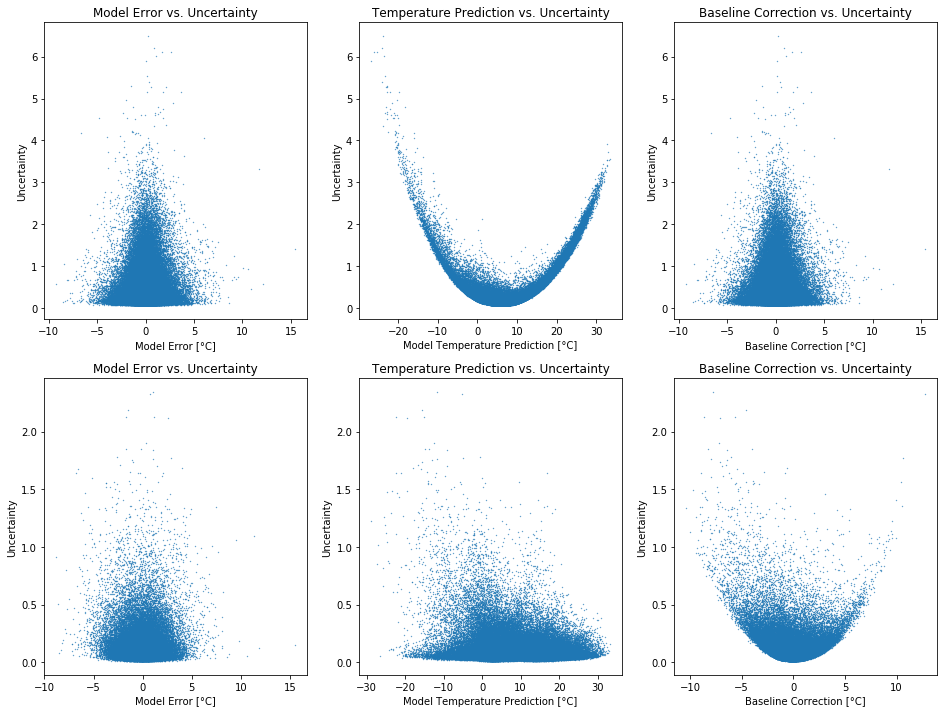

In [213]:
fig, axis = plt.subplots(2,3, figsize=(16,12))

axis[0,0].scatter(model_error_temperature_prediction, var_prediction_temperature_prediction, s=0.1)
axis[0,0].set_xlabel('Model Error [°C]')
axis[0,0].set_ylabel('Uncertainty')
axis[0,0].set_title('Model Error vs. Uncertainty')

axis[0,1].scatter(prediction_temperature_prediction, var_prediction_temperature_prediction, s=0.1)
axis[0,1].set_xlabel('Model Temperature Prediction [°C]')
axis[0,1].set_ylabel('Uncertainty')
axis[0,1].set_title('Temperature Prediction vs. Uncertainty')

axis[0,2].scatter(correction_temperature_prediction, var_prediction_temperature_prediction, s=0.1)
axis[0,2].set_xlabel('Baseline Correction [°C]')
axis[0,2].set_ylabel('Uncertainty')
axis[0,2].set_title('Baseline Correction vs. Uncertainty')

axis[1,0].scatter(model_error_error_prediction, var_prediction_error_prediction, s=0.1)
axis[1,0].set_xlabel('Model Error [°C]')
axis[1,0].set_ylabel('Uncertainty')
axis[1,0].set_title('Model Error vs. Uncertainty')

axis[1,1].scatter(prediction_error_prediction, var_prediction_error_prediction, s=0.1)
axis[1,1].set_xlabel('Model Temperature Prediction [°C]')
axis[1,1].set_ylabel('Uncertainty')
axis[1,1].set_title('Temperature Prediction vs. Uncertainty')

axis[1,2].scatter(correction_error_prediction, var_prediction_error_prediction, s=0.1)
axis[1,2].set_xlabel('Baseline Correction [°C]')
axis[1,2].set_ylabel('Uncertainty')
axis[1,2].set_title('Baseline Correction vs. Uncertainty')

plt.show()

### Plot ditribution of temperature/correction against mean uncertainty

In [214]:
mean_uncertainty_by_temp, temp_edges, _ = binned_statistic(prediction_temperature_prediction.squeeze(),
                                            std_prediction_temperature_prediction.squeeze(),
                                            'mean',
                                            100,
                                            (np.min(prediction_temperature_prediction), np.max(prediction_temperature_prediction)))

mean_uncertainty_by_correction, correction_edges, _ = binned_statistic(correction_error_prediction.squeeze(),
                                            std_prediction_error_prediction.squeeze(),
                                            'mean',
                                            100,
                                            (np.min(correction_error_prediction), np.max(correction_error_prediction)))

In [215]:
Y_temp_train = network_ready_data_error_prediction_train.as_matrix()[:,-2].astype(float)
Y_correction_train = network_ready_data_error_prediction_train.as_matrix()[:,-1].astype(float) - network_ready_data_error_prediction_train.as_matrix()[:,-2].astype(float)

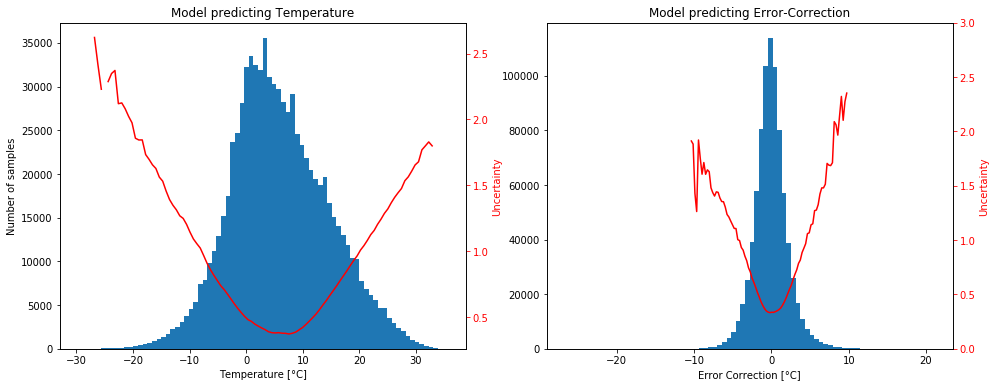

In [216]:
fig, ax = plt.subplots(1,2, figsize=(16,6))

ax[0].hist(Y_temp_train, bins=80)
ax02 = ax[0].twinx()
ax02.plot(temp_edges[:-1], mean_uncertainty_by_temp, color='red')
ax[0].set_xlabel('Temperature [°C]')
ax[0].set_ylabel('Number of samples')
ax02.set_ylabel('Uncertainty', color='red')
ax02.tick_params('y', colors='red')
ax[0].set_title('Model predicting Temperature')

ax[1].hist(Y_correction_train, bins=80)
ax12 = ax[1].twinx()
ax12.plot(correction_edges[:-1], mean_uncertainty_by_correction, color='red')
ax[1].set_xlabel('Error Correction [°C]')
ax12.set_ylabel('Uncertainty', color='red')
ax12.tick_params('y', colors='red')
ax12.set_ylim(0,3)
ax[1].set_title('Model predicting Error-Correction')

plt.show()

# Backup

In [ ]:
fig, axis = plt.subplots(3,3, figsize=(16,16))

axis[0,0].scatter(model_squared_error_per_prediction, std_prediction)
axis[0,0].set_xlabel('Model Error [°C]')
axis[0,0].set_ylabel('Uncertainty')
axis[0,0].set_title('Model Error vs. Uncertainty')

axis[1,0].scatter(np.absolute(model_squared_error_per_prediction), std_prediction)
axis[1,0].set_xlabel('Absolute Model Error [°C]')
axis[1,0].set_ylabel('Uncertainty')
axis[1,0].set_title('Abs. Model Error vs. Uncertainty')

axis[2,0].scatter(correction_per_prediction, std_prediction)
axis[2,0].set_xlabel('Correction [°C]')
axis[2,0].set_ylabel('Uncertainty')
axis[2,0].set_title('Correction vs. Uncertainty')

axis[0,1].scatter(label, std_prediction)
axis[0,1].set_xlabel('Label [°C]')
axis[0,1].set_ylabel('Uncertainty')
axis[0,1].set_title('Label Value vs. Uncertainty')

axis[1,1].scatter(np.absolute(label), std_prediction)
axis[1,1].set_xlabel('Absolute Label [°C]')
axis[1,1].set_ylabel('Uncertainty')
axis[1,1].set_title('Abs. Label Value vs. Uncertainty')

axis[2,1].scatter(prediction, std_prediction)
axis[2,1].set_xlabel('Prediction [°C]')
axis[2,1].set_ylabel('Uncertainty')
axis[2,1].set_title('Prediction vs. Uncertainty')

axis[0,2].scatter(np.absolute(prediction), std_prediction)
axis[0,2].set_xlabel('Absolute Prediction [°C]')
axis[0,2].set_ylabel('Uncertainty')
axis[0,2].set_title('Abs. Prediction vs. Uncertainty')

axis[1,2].scatter(prediction, model_squared_error_per_prediction)
axis[1,2].set_xlabel('Prediction [°C]')
axis[1,2].set_ylabel('Model Error [°C]')
axis[1,2].set_title('Prediction vs. Model Error')

axis[2,2].scatter(np.absolute(prediction), np.absolute(model_squared_error_per_prediction))
axis[2,2].set_xlabel('Absolute Prediction [°C]')
axis[2,2].set_ylabel('Absolute Model Error [°C]')
axis[2,2].set_title('Abs. Prediction vs. Abs. Model Error')

plt.show()

In [ ]:
n_bins = 100

fig, axis = plt.subplots(3,3, figsize=(16,16))

axis[0,0].hist2d(model_squared_error_per_prediction, std_prediction, bins=n_bins)
axis[0,0].set_xlabel('Model Error [°C]')
axis[0,0].set_ylabel('Uncertainty')
axis[0,0].set_title('Model Error vs. Uncertainty')

axis[1,0].hist2d(np.absolute(model_squared_error_per_prediction), std_prediction, bins=n_bins)
axis[1,0].set_xlabel('Absolute Model Error [°C]')
axis[1,0].set_ylabel('Uncertainty')
axis[1,0].set_title('Abs. Model Error vs. Uncertainty')

axis[2,0].hist2d(correction_per_prediction, std_prediction, bins=n_bins)
axis[2,0].set_xlabel('Correction [°C]')
axis[2,0].set_ylabel('Uncertainty')
axis[2,0].set_title('Correction vs. Uncertainty')

axis[0,1].hist2d(label, std_prediction, bins=n_bins)
axis[0,1].set_xlabel('Label [°C]')
axis[0,1].set_ylabel('Uncertainty')
axis[0,1].set_title('Label Value vs. Uncertainty')

axis[1,1].hist2d(np.absolute(label), std_prediction, bins=n_bins)
axis[1,1].set_xlabel('Absolute Label [°C]')
axis[1,1].set_ylabel('Uncertainty')
axis[1,1].set_title('Abs. Label Value vs. Uncertainty')

axis[2,1].hist2d(prediction, std_prediction, bins=n_bins)
axis[2,1].set_xlabel('Prediction [°C]')
axis[2,1].set_ylabel('Uncertainty')
axis[2,1].set_title('Prediction vs. Uncertainty')

axis[0,2].hist2d(np.absolute(prediction), std_prediction, bins=n_bins)
axis[0,2].set_xlabel('Absolute Prediction [°C]')
axis[0,2].set_ylabel('Uncertainty')
axis[0,2].set_title('Abs. Prediction vs. Uncertainty')

axis[1,2].hist2d(prediction, model_squared_error_per_prediction, bins=n_bins)
axis[1,2].set_xlabel('Prediction [°C]')
axis[1,2].set_ylabel('Model Error [°C]')
axis[1,2].set_title('Prediction vs. Model Error')

axis[2,2].hist2d(np.absolute(prediction), np.absolute(model_squared_error_per_prediction), bins=n_bins)
axis[2,2].set_xlabel('Absolute Prediction [°C]')
axis[2,2].set_ylabel('Absolute Model Error [°C]')
axis[2,2].set_title('Abs. Prediction vs. Abs. Model Error')

plt.show()

### Plot uncertainty correlation with features

In [ ]:
feature_names = network_ready_data.columns[2:-2]

fig, axis = plt.subplots(10,3, figsize=(16,56))

for idx, feature_name in enumerate(feature_names):
    x_idx = idx%10
    y_idx = int(idx/10)
    axis[x_idx,y_idx].scatter(data[:,idx], std_prediction)
    axis[x_idx,y_idx].set_xlabel('Feature Value')
    axis[x_idx,y_idx].set_ylabel('Uncertainty')
    axis[x_idx,y_idx].set_title('%s vs. Uncertainty' % feature_names[idx])

plt.show()

In [ ]:
feature_names = network_ready_data.columns[2:-2]
n_bins = 100

fig, axis = plt.subplots(10,3, figsize=(16,56))

for idx, feature_name in enumerate(feature_names):
    x_idx = idx%10
    y_idx = int(idx/10)
    axis[x_idx,y_idx].hist2d(data[:,idx], std_prediction, bins=n_bins)
    axis[x_idx,y_idx].set_xlabel('Feature Value')
    axis[x_idx,y_idx].set_ylabel('Uncertainty')
    axis[x_idx,y_idx].set_title('%s vs. Uncertainty' % feature_names[idx])

plt.show()

### Uncertainty estimation on train vs. test data

### Load network ready train and test data

In [ ]:
with open('/mnt/ds3lab-scratch/ninow/preprocessed_data/network_ready_data/test_data','rb') as handle:
    network_ready_test_data = pkl.load(handle)
with open('/mnt/ds3lab-scratch/ninow/preprocessed_data/network_ready_data/train_data','rb') as handle:
    network_ready_train_data = pkl.load(handle)

### Run model 100 times with dropout

In [ ]:
n_eval = 100
batch_size = 10000
data_test = np.array(network_ready_test_data.as_matrix()[:,2:-2], dtype=np.float64)
ensemble_result_test = np.zeros((n_eval, network_ready_test_data.shape[0]))
for run in range(n_eval):
    net.train(True)
    for batch_idx in np.arange(data_test.shape[0])[::batch_size]:
        batched_data = data_test[batch_idx:batch_idx+batch_size]
        ensemble_result_test[run, batch_idx:batch_idx+batch_size] = network_output_wrapper(net, batched_data)[:,0]

In [ ]:
n_eval = 100
batch_size = 10000
data_train = np.array(network_ready_train_data.as_matrix()[:,2:-2], dtype=np.float64)
ensemble_result_train = np.zeros((n_eval, network_ready_train_data.shape[0]))
for run in range(n_eval):
    net.train(True)
    for batch_idx in np.arange(data_train.shape[0])[::batch_size]:
        batched_data = data_train[batch_idx:batch_idx+batch_size]
        ensemble_result_train[run, batch_idx:batch_idx+batch_size] = network_output_wrapper(net, batched_data)[:,0]

In [ ]:
mean_prediction_train, std_prediction_train = np.mean(ensemble_result_train, axis=0), np.std(ensemble_result_train, axis=0)
mean_prediction_test, std_prediction_test = np.mean(ensemble_result_test, axis=0), np.std(ensemble_result_test, axis=0)

In [ ]:
train_rmse = np.sqrt(np.nanmean(np.square(mean_prediction_train - np.array(network_ready_train_data.as_matrix()[:,-2], dtype=np.float64))))
test_rmse = np.sqrt(np.nanmean(np.square(mean_prediction_test - np.array(network_ready_test_data.as_matrix()[:,-2], dtype=np.float64))))
train_std = np.mean(std_prediction_train)
test_std = np.mean(std_prediction_test)

In [ ]:
train_rmse, test_rmse, train_std, test_std

### Plot ditribution of temperature

In [ ]:
mean_prediction_test, std_prediction_test = np.mean(ensemble_result_test, axis=0), np.std(ensemble_result_test, axis=0)

In [ ]:
mean_uncertainty_by_temp_test = binned_statistic(temp_data_train.squeeze(),
                                            std_prediction_test.squeeze(),
                                            'mean',
                                            100,
                                            (0, 1)).statistic

In [ ]:
temp_data_test = network_ready_test_data[['2m-Temperature']].as_matrix()

fig, ax1 = plt.subplots()
ax1.hist(temp_data_test, bins=100)
ax2 = ax1.twinx()
ax2.plot(np.arange(0,1,0.01),mean_uncertainty_by_temp, color='red')
plt.show()

In [ ]:
temp_data_train = network_ready_train_data[['2m-Temperature']].as_matrix()

fig, ax1 = plt.subplots()
ax1.hist(temp_data_train, bins=100)
ax2 = ax1.twinx()
ax2.plot(np.arange(0,1,0.01), mean_uncertainty_by_temp, color='red')
plt.show()

In [ ]:
model_error_test = np.absolute(mean_prediction_test - np.array(network_ready_test_data.as_matrix()[:,-2], dtype=np.float64))

mean_error_by_temp_test = binned_statistic(temp_data_test.squeeze(),
                                            model_error_test.squeeze(),
                                            'mean',
                                            100,
                                            (0, 1)).statistic

In [ ]:
fig, ax1 = plt.subplots()
ax1.hist(temp_data_train, bins=100)
ax2 = ax1.twinx()
ax2.plot(np.arange(0,1,0.01), mean_error_by_temp_test, color='red')
plt.show()

### Calculate binned variance

In [ ]:
model_error_test = np.absolute(mean_prediction_test - np.array(network_ready_test_data.as_matrix()[:,-2], dtype=np.float64))

std_by_temp_test = binned_statistic(temp_data_test.squeeze(),
                                            model_error_test.squeeze(),
                                            lambda bin_data: np.std(bin_data),
                                            100,
                                            (0, 1)).statistic

In [ ]:
fig, ax1 = plt.subplots()
ax1.hist(temp_data_train, bins=100)
ax2 = ax1.twinx()
ax2.plot(np.arange(0,1,0.01), std_by_temp_test, color='red')
plt.show()